### This workflow resamples downscaled CMIP6 data to a monthly temporal resolution. ### 

`gs://{CRS_SUPPORT_BUCKET}/internal_datasets/climate/CMIP6/gridded-climate-data` 

In [1]:
%matplotlib inline 
import xarray as xr 
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(1, '/home/jovyan/downscaleCMIP6/notebooks/downscaling_pipeline/post_processing_and_delivery/')
import dc6_functions

# OLD BUCKET
bucket = os.environ['CRS_SUPPORT_BUCKET']

# NEW support BUCKET
bucket = 'support-f8a48a9e'

ds_bucket = 'downscaled-48ec31ab'

In [2]:
import dask
import rhg_compute_tools.kubernetes as rhgk
import rhg_compute_tools.utils as rhgu
import dask.distributed as dd
import zarr
from tqdm.auto import tqdm

/tmp/ipykernel_17967/3435993731.py:2: DeprecationWarning: rhg_compute_tools and the associated command-line application rctools are
deprecated on catalyst clusters. use catalyst_compute_tools instead.
See https://gitlab.com/crs-catalyst/infrastructure/catalyst_compute_tools/-/issues/1
  import rhg_compute_tools.kubernetes as rhgk


In [3]:
print(xr.__version__)

2022.3.0


In [4]:
print(zarr.__version__)

2.11.3


In [5]:
print()

In [6]:
bucket

'support-f8a48a9e'

`downscaled-48ec31ab/derived/monthly-aggregates-v1.1/`

In [7]:
client, cluster = rhgk.get_standard_cluster()

In [8]:
cluster

In [25]:
variables = ['tasmax', 'tavg', 'pr']
models = dc6_functions.get_cmip6_models()
institutions = dc6_functions.get_cmip6_institutions()
ensemble_members = dc6_functions.get_cmip6_ensemble_members()
# rename variable attributes
long_names = {'tasmax': 'Monthly mean of Daily Maximum Near-Surface Air Temperature', 'tasmin': 'Monthly mean of Daily Minimum Near-Surface Air Temperature', 'pr': 'Monthly sum of Daily Total Precipitation', 'tavg': 'Monthly mean of Daily Average Near-Surface Air Temperature'}

# test zarr 
# ds = xr.open_zarr('gs://{bucket}/internal_datasets/climate/CMIP6/gridded-climate-data/R_CIL_GDPCIR-v1.1/ScenarioMIP/MIROC/MIROC-ES2L/ssp370/r1i1p1f2/day/tasmax/v1.1.zarr'.format(bucket=CRS_SUPPORT_BUCKET))

add pattern models to workflow 

In [10]:
CMIP6_NONCOASTAL_PATTERN_MODELS_BY_SCENARIO = {
    "ssp245": [
        "pattern_ssp245_1_0.96_INM-CM5-0",
        "pattern_ssp245_2_0.96_INM-CM4-8",
        "pattern_ssp245_3_1.14_MPI-ESM1-2-LR",
        "pattern_ssp245_4_1.14_NorESM2-MM",
        "pattern_ssp245_5_1.29_EC-Earth3-Veg-LR",
        "pattern_ssp245_6_1.29_MIROC-ES2L",
        "pattern_ssp245_14_1.74_EC-Earth3",
    ],
    "ssp370": [
        "pattern_ssp370_1_1.68_NorESM2-LM",
        "pattern_ssp370_2_1.68_MIROC6",
        "pattern_ssp370_3_1.95_INM-CM5-0",
        "pattern_ssp370_4_1.95_MIROC-ES2L",
        "pattern_ssp370_5_2.12_EC-Earth3-Veg",
        "pattern_ssp370_6_2.12_BCC-CSM2-MR",
        "pattern_ssp370_16_2.89_ACCESS-CM2",
        "pattern_ssp370_17_2.89_EC-Earth3-Veg-LR",
    ],
}

In [11]:
for model in CMIP6_NONCOASTAL_PATTERN_MODELS_BY_SCENARIO['ssp245']:
    print(model)

pattern_ssp245_1_0.96_INM-CM5-0
pattern_ssp245_2_0.96_INM-CM4-8
pattern_ssp245_3_1.14_MPI-ESM1-2-LR
pattern_ssp245_4_1.14_NorESM2-MM
pattern_ssp245_5_1.29_EC-Earth3-Veg-LR
pattern_ssp245_6_1.29_MIROC-ES2L
pattern_ssp245_14_1.74_EC-Earth3


### previously, we updated the list of models to only include those for which we have waivers (e.g. BLK list) ### 

As of 4/17/2023, where this workflow is now being used for the downscaling paper, we now include all models. 

In [12]:
add_models = ['CanESM5', 'CMCC-ESM2', 'CMCC-CM2-SR5']

old code from when we restricted models for BLK due to licensing restrictions, and this wasn't being used for downscaling

In [13]:
'''models_to_remove = ['CanESM5', 'CMCC-ESM2', 'CMCC-CM2-SR5']
for k in models_to_remove:
    models.pop(k, None)
assert len(models) == 22'''

"models_to_remove = ['CanESM5', 'CMCC-ESM2', 'CMCC-CM2-SR5']\nfor k in models_to_remove:\n    models.pop(k, None)\nassert len(models) == 22"

In [14]:
# print(models)

# wanted_keys = ['BCC-CSM2-MR', 'FGOALS-g3'] # The keys you want
wanted_keys = ['CanESM5', 'CMCC-ESM2', 'CMCC-CM2-SR5'] # The keys you want
models_subset = dict((k, models[k]) for k in wanted_keys if k in models)

In [15]:
models_subset

{'CanESM5': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'CMCC-ESM2': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'CMCC-CM2-SR5': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']}

4/17/2023 update: run for models that previously had a non-commercial clause (now all are CC-BY), e.g. the above three models. Also, update all paths - downscaled data has been migrated. 

NOTE: pattern model paths below have not been updated, as they aren't used in the downscaling paper. So the below code for patt models will not run without paths being updated. 

In [ ]:
test_patt_model = xr.open_zarr('gs://support-data-cc7330d0/internal_datasets/climate/CMIP6/SMME/pattern-scaled-and-finalized-models/pattern-scaling-v1.0/ScenarioMIP/pattern_ssp245_1_0.96_INM-CM5-0/ssp245/day/tavg/v1.0.zarr')

In [ ]:
test_patt_model

In [24]:
! gsutil ls gs://downscaled-48ec31ab/derived/monthly-aggregates-v1.1/ScenarioMIP/INM/INM-CM5-0/ssp245/*

gs://downscaled-48ec31ab/derived/monthly-aggregates-v1.1/ScenarioMIP/INM/INM-CM5-0/ssp245/r1i1p1f1/month/


In [17]:
test_gcm_model = xr.open_zarr('gs://{ds_bucket}/derived/monthly-aggregates-v1.1/ScenarioMIP/INM/INM-CM5-0/ssp245/r1i1p1f1/month/tavg/v1.1.zarr'.format(ds_bucket=ds_bucket), consolidated=True)

In [27]:
# patt_slice = test_patt_model['tavg'].sel(time=slice("2015-01-01", "2015-07-01")).load()

In [28]:
# test_patt_model['tavg'].resample(time="M").mean()

In [18]:
def resample_monthly(ds, variable='tavg'):
    if variable == 'pr':
        da_monthly = ds[variable].resample(time="MS").sum() # where M is for months
    else: 
        da_monthly = ds[variable].resample(time="MS").mean() # where M is for months
    return da_monthly

In [19]:
# test_patt_model.isel(lat=0, lon=0).resample(time="M").mean()

In [20]:
# test_patt_model.time

In [ ]:
time = xr.cftime_range("2015-01", "2101-01", freq="M", calendar='noleap')
month = xr.DataArray(time.month, coords={"time": time}, dims=["time"])
np.random.seed(123)
array = xr.DataArray(
    np.random.rand(len(time), 720, 1440),
    dims=["time", "lat", "lon"],
    coords={"time": time, "lat": test_patt_model.lat, "lon": test_patt_model.lon},
).chunk({'time':12, 'lat': 90, 'lon': 90})

In [ ]:
test_resample = xr.map_blocks(resample_monthly, test_patt_model, template=array).compute()

In [ ]:
test_resample = test_resample.persist()

In [ ]:
test_resample.to_dataset(name='tavg')

NOTE: updated `get_ds_path` function after Oregon trail migration, now using downscaling bucket vs CRS_SUPPORT_BUCKET

In [33]:
# get downscaled zarr path (dc6_functions analog doesn't work on catalyst)
def get_ds_path(bucket, version, institution, model, experiment, ensemble_member, variable, frequency):
    if experiment == 'historical':
        activity = 'CMIP'
    else:
        activity = 'ScenarioMIP'
    # account for exception with historical institution being MPI-M and SSPs are DKRZ
    if (model == 'MPI-ESM1-2-HR') and (experiment == 'historical'):
        institution = 'MPI-M'
    '''zarr_path = 'gs://{CRS_SUPPORT_BUCKET}/internal_datasets/climate/CMIP6/gridded-climate-data/R_CIL_GDPCIR-{version}/{activity_id}/{institution_id}/{source_id}/{experiment_id}/{member_id}/{table_id}/{variable_id}/{version}.zarr'.format(CRS_SUPPORT_BUCKET=bucket, 
    version=version, institution_id=institution, source_id=model, member_id=ensemble_member, variable_id=variable, activity_id=activity, experiment_id=experiment, table_id=frequency)'''
    if frequency == 'day':
        if variable == 'tavg':
            # tavg daily data in a new location 
            zarr_path = 'gs://{ds_bucket}/derived/tavg-daily-v1.1/{activity_id}/{institution_id}/{source_id}/{experiment_id}/{member_id}/{table_id}/{variable_id}/{version}.zarr'.format(ds_bucket=ds_bucket, version=version, institution_id=institution, source_id=model, member_id=ensemble_member, variable_id=variable, activity_id=activity, experiment_id=experiment, table_id=frequency)
        else:
            zarr_path = 'gs://{bucket}/outputs/{activity_id}/{institution_id}/{source_id}/{experiment_id}/{member_id}/{table_id}/{variable_id}/{version}.zarr'.format(bucket=ds_bucket, 
            version=version, institution_id=institution, source_id=model, member_id=ensemble_member, variable_id=variable, activity_id=activity, experiment_id=experiment, table_id=frequency)
    elif frequency == 'month':
        zarr_path = 'gs://{ds_bucket}/derived/monthly-aggregates-v1.1/{activity_id}/{institution_id}/{source_id}/{experiment_id}/{member_id}/{table_id}/{variable_id}/{version}.zarr'.format(ds_bucket=ds_bucket, version=version, institution_id=institution, source_id=model, member_id=ensemble_member, variable_id=variable, activity_id=activity, experiment_id=experiment, table_id=frequency)
    else: 
        raise ValueError("function not defined for this temporal frequency")
    
    return zarr_path

In [17]:
def get_patternmodel_path(bucket, pattern_model, scenario, variable, frequency):
    
    zarr_path = 'gs://{CRS_SUPPORT_BUCKET}/internal_datasets/climate/CMIP6/SMME/pattern-scaled-and-finalized-models/pattern-scaling-v1.0/ScenarioMIP/{pattern_model}/{scenario}/{table_id}/{variable_id}/v1.0.zarr'.format(CRS_SUPPORT_BUCKET=bucket, pattern_model=pattern_model, scenario=scenario, variable_id=variable, table_id=frequency)
    
    return zarr_path

In [18]:
# get_patternmodel_path(bucket, "pattern_ssp370_1_1.68_NorESM2-LM", "ssp370", "tavg", "day")

In [34]:
def create_daily_downscaled_tavg(model, models_dict, institutions, ensemble_members, long_names):
    """
    take in model and create daily tavg data for historical and SSPs  
    
    """
    
    for scenario in models_dict[model]:
    
        ds_tasmax = xr.open_zarr(get_ds_path(bucket=bucket, version='v1.1', institution=institutions[model], model=model, experiment=scenario, ensemble_member=ensemble_members[model], variable='tasmax', frequency='day'), consolidated=True)
        
        tasmax = ds_tasmax['tasmax']

        tasmin = xr.open_zarr(get_ds_path(bucket=bucket, version='v1.1', institution=institutions[model], model=model, experiment=scenario, ensemble_member=ensemble_members[model], variable='tasmin', frequency='day'), consolidated=True)['tasmin']

        tavg = (tasmax + tasmin) / 2

        # preserve but also update attributes 
        attrs = ds_tasmax.attrs
        var_attrs = {'comment': 'average near-surface (usually, 2 meter) air temperature', 
                     'long_name': 'Daily Average Near-Surface Air Temperature', 
                     'standard_name': 'air_temperature', 
                     'units': 'K', 
                     'method': 'average of downscaled tasmax and downscaled tasmin'}

        # update frequency and variable long_name
        attrs['variable_id'] = 'tavg'


        tavg = tavg.persist()
        
        tavg = tavg.to_dataset(name='tavg')
        
        tavg.attrs = attrs
        tavg['tavg'].attrs = var_attrs

        # define path for writing monthly output. same as input path except change table_id field 
        tavg_daily_path = get_ds_path(bucket=bucket, version='v1.1', institution=institutions[model], model=model, experiment=scenario, ensemble_member=ensemble_members[model], variable='tavg', frequency='day')

        # write zarr
        print("writing zarr to {}".format(tavg_daily_path))
        tavg.to_zarr(tavg_daily_path, consolidated=True, mode='w')
        print("wrote zarr to {}".format(tavg_daily_path))
    
    

create downscaled tavg for new (previously non commercial, now cc-by) models 

In [35]:
models_subset

{'CanESM5': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'CMCC-ESM2': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'CMCC-CM2-SR5': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']}

In [23]:
# create_daily_downscaled_tavg(model, models_dict, institutions, ensemble_members, long_names)
create_daily_downscaled_tavg('CMCC-CM2-SR5', models, institutions, ensemble_members, long_names)

writing zarr to gs://downscaled-48ec31ab/derived/tavg-daily-v1.1/CMIP/CMCC/CMCC-CM2-SR5/historical/r1i1p1f1/day/tavg/v1.1.zarr
wrote zarr to gs://downscaled-48ec31ab/derived/tavg-daily-v1.1/CMIP/CMCC/CMCC-CM2-SR5/historical/r1i1p1f1/day/tavg/v1.1.zarr
writing zarr to gs://downscaled-48ec31ab/derived/tavg-daily-v1.1/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp126/r1i1p1f1/day/tavg/v1.1.zarr
wrote zarr to gs://downscaled-48ec31ab/derived/tavg-daily-v1.1/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp126/r1i1p1f1/day/tavg/v1.1.zarr
writing zarr to gs://downscaled-48ec31ab/derived/tavg-daily-v1.1/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp245/r1i1p1f1/day/tavg/v1.1.zarr
wrote zarr to gs://downscaled-48ec31ab/derived/tavg-daily-v1.1/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp245/r1i1p1f1/day/tavg/v1.1.zarr
writing zarr to gs://downscaled-48ec31ab/derived/tavg-daily-v1.1/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp370/r1i1p1f1/day/tavg/v1.1.zarr
wrote zarr to gs://downscaled-48ec31ab/derived/tavg-daily-v1.1/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp370/r1

In [26]:
variables

['tasmax', 'tavg', 'pr']

In [36]:
def create_monthly_downscaled_data(model, models_dict, variables, institutions, ensemble_members, long_names):
    """
    take in model and create monthly data for historical and SSPs for tas and pr  
    """
    
    # loop over variables 
    for variable in variables: 
        print(variable)
    
        # loop over scenarios
        for scenario in models_dict[model]:


            zarr_path = get_ds_path(bucket=bucket, version='v1.1', institution=institutions[model], model=model, experiment=scenario, ensemble_member=ensemble_members[model], variable=variable, frequency='day')

            ds_daily = xr.open_zarr(zarr_path, consolidated=True)

            if variable == 'pr':
                ds_monthly = ds_daily.resample(time="M").sum() # where M is for months
            else: 
                ds_monthly = ds_daily.resample(time="M").mean() # where M is for months

            # preserve attributes 
            attrs = ds_daily.attrs
            var_attrs = ds_daily[variable].attrs
            
            # update frequency and variable long_name
            attrs['frequency'] = 'month'
            var_attrs['long_name'] = long_names[variable]

            # compute
            ds_monthly = ds_monthly.persist()

            # update attrs
            ds_monthly.attrs = attrs
            ds_monthly[variable].attrs = var_attrs

            # define path for writing monthly output. same as input path except change table_id field 
            zarr_month_path = get_ds_path(bucket=bucket, version='v1.1', institution=institutions[model], model=model, experiment=scenario, ensemble_member=ensemble_members[model], variable=variable, frequency='month')

            # write zarr
            print("writing zarr to {}".format(zarr_month_path))
            ds_monthly.to_zarr(zarr_month_path, consolidated=True, mode='w')
            print("wrote zarr to {}".format(zarr_month_path))

create monthly data for "new" models (4/18/2023)

In [37]:
print(models_subset)
print(variables)

{'CanESM5': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'], 'CMCC-ESM2': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'], 'CMCC-CM2-SR5': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']}
['tasmax', 'tavg', 'pr']


In [38]:
for model in tqdm(models_subset):
    print(model)
    create_monthly_downscaled_data(model, models, variables, institutions, ensemble_members, long_names)

  0%|          | 0/3 [00:00<?, ?it/s]

CanESM5
tasmax
writing zarr to gs://downscaled-48ec31ab/derived/monthly-aggregates-v1.1/CMIP/CCCma/CanESM5/historical/r1i1p1f1/month/tasmax/v1.1.zarr
wrote zarr to gs://downscaled-48ec31ab/derived/monthly-aggregates-v1.1/CMIP/CCCma/CanESM5/historical/r1i1p1f1/month/tasmax/v1.1.zarr
writing zarr to gs://downscaled-48ec31ab/derived/monthly-aggregates-v1.1/ScenarioMIP/CCCma/CanESM5/ssp126/r1i1p1f1/month/tasmax/v1.1.zarr
wrote zarr to gs://downscaled-48ec31ab/derived/monthly-aggregates-v1.1/ScenarioMIP/CCCma/CanESM5/ssp126/r1i1p1f1/month/tasmax/v1.1.zarr
writing zarr to gs://downscaled-48ec31ab/derived/monthly-aggregates-v1.1/ScenarioMIP/CCCma/CanESM5/ssp245/r1i1p1f1/month/tasmax/v1.1.zarr
wrote zarr to gs://downscaled-48ec31ab/derived/monthly-aggregates-v1.1/ScenarioMIP/CCCma/CanESM5/ssp245/r1i1p1f1/month/tasmax/v1.1.zarr
writing zarr to gs://downscaled-48ec31ab/derived/monthly-aggregates-v1.1/ScenarioMIP/CCCma/CanESM5/ssp370/r1i1p1f1/month/tasmax/v1.1.zarr
wrote zarr to gs://downscaled-4

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


In [28]:
def create_monthly_patternmodel_data(model, scenario, variable, long_names):
    """
    take in model and create monthly data for historical and SSPs for tas and pr  
    """
    
    zarr_path = get_patternmodel_path(bucket, model, scenario, variable, frequency='day')
    print(zarr_path)

    ds_daily = xr.open_zarr(zarr_path, consolidated=True)
    
    ds_daily = ds_daily.chunk({'time': 365, 'lat': 360, 'lon': 360})
    ds_daily = ds_daily.persist()

    if variable == 'pr':
        ds_monthly = ds_daily.resample(time="M").sum() # where M is for months
    else: 
        ds_monthly = ds_daily.resample(time="M").mean() # where M is for months
    
    # preserve attributes 
    attrs = ds_daily.attrs
    var_attrs = ds_daily[variable].attrs
            
    # update frequency and variable long_name
    attrs['frequency'] = 'month'
    var_attrs['long_name'] = long_names[variable]

    # compute
    ds_monthly = ds_monthly.persist()

    # update attrs
    ds_monthly.attrs = attrs
    ds_monthly[variable].attrs = var_attrs

    # define path for writing monthly output. same as input path except change table_id field 
    zarr_month_path = get_patternmodel_path(bucket, model, scenario, variable, frequency='month')

    # write zarr
    ds_monthly.to_zarr(zarr_month_path, consolidated=True, mode='w')
    
    print("wrote zarr to {}".format(zarr_month_path))

In [ ]:
# test pattern models 
create_monthly_patternmodel_data('pattern_ssp245_1_0.96_INM-CM5-0', 'ssp245', 'tavg', long_names)

debug pattern model code

In [ ]:
'''for model in tqdm(models):
    print(model)
    create_daily_downscaled_tavg(model, models, institutions, ensemble_members, long_names)'''

In [ ]:
# test pattern models 
create_monthly_patternmodel_data('pattern_ssp245_1_0.96_INM-CM5-0', 'ssp245', 'tavg', long_names)

In [25]:
# loop over scenarios, variables and pattern models 

for scenario in ['ssp245', 'ssp370']:
    for model in CMIP6_NONCOASTAL_PATTERN_MODELS_BY_SCENARIO[scenario]:
        for variable in variables: 
            print("now producing monthly data for {} {} {}".format(scenario, model, variable))
            create_monthly_patternmodel_data(model, scenario, variable, long_names)

'# loop over scenarios, variables and pattern models \n\nfor scenario in [\'ssp245\', \'ssp370\']:\n    for model in CMIP6_NONCOASTAL_PATTERN_MODELS_BY_SCENARIO[scenario]:\n        for variable in variables: \n            print("now producing monthly data for {} {} {}".format(scenario, model, variable))\n            create_monthly_patternmodel_data(model, scenario, variable, long_names)'

In [ ]:
for model in tqdm(models):
    print(model)
    create_monthly_downscaled_data(model, models, variables, institutions, ensemble_members, long_names)

check tavg data 

In [ ]:
model = 'EC-Earth3-Veg-LR'
scenario = 'ssp585'
tavg_ssp585 = xr.open_zarr(get_ds_path(bucket=bucket, version='v1.1', institution=institutions[model], model=model, experiment=scenario, ensemble_member=ensemble_members[model], variable='tavg', frequency='day'), consolidated=True)
# look at a slice 
tavg_ssp585['tavg'].isel(time=0).plot()

In [15]:
tavg_test = xr.open_zarr('gs://support-data-cc7330d0/internal_datasets/climate/CMIP6/SMME/pattern-scaled-and-finalized-models/pattern-scaling-v1.0/ScenarioMIP/pattern_ssp370_17_2.89_EC-Earth3-Veg-LR/ssp370/month/tavg/v1.0.zarr')

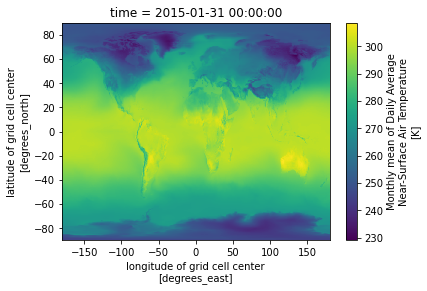

In [16]:
tavg_test['tavg'].isel(time=0).plot()

check monthly data 

In [ ]:
model = 'FGOALS-g3'
scenario = 'ssp585'
'''tavg_ssp585 = xr.open_zarr(get_ds_path(bucket=bucket, version='v1.1', institution=institutions[model], model=model, experiment=scenario, ensemble_member=ensemble_members[model], variable='tavg', frequency='month'), consolidated=True)'''
pr_ssp585 = xr.open_zarr(get_ds_path(bucket=bucket, version='v1.1', institution=institutions[model], model=model, experiment=scenario, ensemble_member=ensemble_members[model], variable='pr', frequency='month'), consolidated=True)
print(get_ds_path(bucket=bucket, version='v1.1', institution=institutions[model], model=model, experiment=scenario, ensemble_member=ensemble_members[model], variable='pr', frequency='month'))
# look at a slice 
# tavg_ssp585['tavg'].isel(time=0).plot()
pr_ssp585['pr'].isel(time=0).plot(robust=True)

In [ ]:
pr_ssp585['pr']

In [ ]:
model = 'NorESM2-LM'
variable = 'tavg'
version = 'v1.1'

u = xr.open_zarr(get_ds_path(bucket, version, institutions[model], model, 'ssp245', ensemble_members[model], variable, 'day'))

In [ ]:
attrs = {'comment': 'average near-surface (usually, 2 meter) air temperature', 
        'long_name': long_names['tavg'], 
        'standard_name': 'air_temperature', 
        'units': 'K', 
        'method': 'average of downscaled tasmax and downscaled tasmin'}
attrs

In [ ]:
u['tavg'].attrs

In [ ]:
test_read_in = xr.open_zarr('gs://support-data-cc7330d0/internal_datasets/climate/CMIP6/SMME/pattern-scaled-and-finalized-models/pattern-scaling-v1.0/ScenarioMIP/pattern_ssp245_1_0.96_INM-CM5-0/ssp245/month/tavg/v1.0.zarr', consolidated=True)

In [17]:
tavg_test['tavg'].isnull().sum().values

array(0)